# Importing important libraries

In [78]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')


In [79]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight



# defining some important constants

In [80]:
data_dir = "data"
img_size = (224, 224)
img_channels = 3
batch_size = 8

# loading the data using, and dividing into training and testing

In [81]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=50)
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=50)


Found 279 files belonging to 5 classes.
Using 224 files for training.
Found 279 files belonging to 5 classes.
Using 55 files for validation.


In [82]:
train.class_names

['dipak', 'me', 'ram', 'shyam', 'unknown']

# defining the labels of our model's prediction

In [83]:
class_names = train.class_names
num_classes = len(class_names)

# calculating weights of each classes

In [85]:
all_labels = []
for _, labels in train:
    all_labels.extend(labels.numpy())

class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(num_classes),
    y=np.array(all_labels)
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}


# defining the layers of our model

In [ ]:
normalization_layer = layers.Rescaling(1./255)
# normalizing the image by diving by 255

In [ ]:
#using data augmentation, because we have few image samples
augmentation_layer = keras.Sequential([
    layers.RandomRotation(factor=0.15, fill_mode='reflect'),
    layers.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='reflect'),
    layers.RandomBrightness(factor=0.15),
    layers.RandomContrast(factor=0.15),
    layers.RandomTranslation(height_factor=0.08, width_factor=0.08, fill_mode='reflect'),
    layers.GaussianNoise(0.008),
], name="augmentation_layer")

In [ ]:
#defining a preprocess function to preprocess the images loaded
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [ ]:
def apply_augmentation(x, y):
    x = augmentation_layer(x, training=True)
    return x, y
#applying the augmentation to our input data

In [ ]:
train_x = train.map(preprocess).map(apply_augmentation)#applying the preprocessing and augmentation to our training data
test_x = test.map(preprocess)#and applying preprocessing to our test/validation data


In [91]:
train_x

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#using the prebuilt methods for faster processing
def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_x = configure_dataset(train_x)
test_x = configure_dataset(test_x)



In [ ]:
# I've decided to use MobileNetV2 as our base model, for feature extraction and fine tuining
base_model = MobileNetV2(
            input_shape=img_size + (img_channels,),#input shape = (128,128,3)
            include_top=False,           # Remove ImageNet classification head
            weights='imagenet',          # using the weights of the imagenet on mobilenet's architecture
            pooling='avg'                
        )

In [ ]:
#freezing the layers of the base model
base_model.trainable = False

In [95]:
trainable_count = sum([layer.trainable for layer in base_model.layers])
print(f"   Frozen layers: {len(base_model.layers) - trainable_count}")
print(f"   Trainable layers: {trainable_count}")

   Frozen layers: 155
   Trainable layers: 0


# building the model

In [ ]:
from tensorflow.keras import regularizers
regularizer = regularizers.l2(0.001) #using L2 regularizer with 0.001 lambda to help prevent overfitting


In [ ]:
inputs = keras.Input(shape=img_size+(img_channels,), name='input_layer')#input layers for receiving our image data
x = base_model(inputs, training=False)#passing the images through our base model
x = layers.Dropout(0.2)(x)#adding a dropout of 0.2
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizer)(x)#dense layer 1 withe regularizer
x = layers.BatchNormalization()(x)#normalization
x = layers.Dropout(0.1)(x)  # another dropout
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizer)(x)#dense layer 2
x = layers.BatchNormalization()(x)#normalization
x = layers.Dropout(0.1)(x)  # dropout
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)#final output layer, using the softmax activation function
model = models.Model(inputs=inputs, outputs=outputs)#putting it together

In [ ]:
#let's chek our model's architecture
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,997 (10.00 MB)

 Trainable params: 362,245 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [ ]:
#creating a checkpoint to save the model whenever it hits the best accuracy
checkpoint_cb = callbacks.ModelCheckpoint(
    'palm_model.keras',
    monitor='val_accuracy',#comparing the validation accuracy
    save_best_only=True,
    mode='max',#save with the highest accuracy
    verbose=1#logging info 
)
#adding earlystopping callback to stop training if the model's performance doesn't increase after 25 epoches
early_stop_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=25,# wait for 25 epoches
    restore_best_weights=True,#choose the best weight and stop
    verbose=1
)
# another one to reduce the learning rate based on the improvements on validation loss
reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',#look at the validation loss
    factor=0.5,#reduce the learning rate by 0.5
    patience=8,#wait for 8 epoches
    min_lr=1e-7,#minimum value of learning rate
    verbose=1
)

In [ ]:
#compiling the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the model (with base model freezed)

In [ ]:
#training the model, first phase
train_1 = model.fit(
    train_x,
    epochs=30,#going for 30 epoches, as lower epoches didn't worked out well, and we do have callbacks for stopping
    validation_data=test_x,#giving the validation data
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],#adding the callbacks
    class_weight = class_weight_dict,#passing the class weights
    verbose=1
)

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.1915 - loss: 3.0273
Epoch 1: val_accuracy improved from None to 0.18182, saving model to best_model_v3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 574ms/step - accuracy: 0.1964 - loss: 2.7613 - val_accuracy: 0.1818 - val_loss: 2.9456 - learning_rate: 0.0010
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2637 - loss: 2.3228
Epoch 2: val_accuracy improved from 0.18182 to 0.40000, saving model to best_model_v3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.2455 - loss: 2.3024 - val_accuracy: 0.4000 - val_loss: 2.2852 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1991 - loss: 2.3337
Epoch 3: val_accuracy improved from 0.40000 to 0.47273, saving model to best_model_v3.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.2500 - loss: 2.2783 - val_accuracy: 0.4727 - val_loss: 2.3255 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 177

# unfreezing the base model

In [102]:
base_model.trainable = True

In [ ]:
for layer in base_model.layers[:-40]:
    layer.trainable = False#unfreezing only the last 10 layers of the base model

In [ ]:
trainable_count = sum([layer.trainable for layer in model.layers])
print(f"Trainable layers: {trainable_count}")

Trainable layers: 10


In [ ]:
# recompiling the model after unfreezing some of the layers
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#training the model once again
train_2 = model.fit(
    train_x,
    epochs=30,  
    validation_data=test_x,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    verbose=1
)

Epoch 1/30


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2924 - loss: 2.5571
Epoch 1: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - accuracy: 0.2857 - loss: 2.4905 - val_accuracy: 0.6182 - val_loss: 2.4533 - learning_rate: 1.0000e-05
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3509 - loss: 2.0235
Epoch 2: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.3616 - loss: 2.0197 - val_accuracy: 0.5455 - val_loss: 2.6104 - learning_rate: 1.0000e-05
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4122 - loss: 1.7348
Epoch 3: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.4196 - loss: 1.7414 - val_accuracy: 0.5455 - val_loss: 2.8022 - learning_rate: 1.0000e-05
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.4898 - loss: 1.6337
Epoch 4: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 

Not much improvements

# Evaluating the model's performance

In [107]:

train_loss, train_acc = model.evaluate(train_x, verbose=1)
val_loss, val_acc = model.evaluate(test_x, verbose=1)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.5000 - loss: 1.6400
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6182 - loss: 2.4533
Training Accuracy: 50.00%
Validation Accuracy: 61.82%


# visualizing the confusion matrix


Classification Report:
              precision    recall  f1-score   support

       dipak       0.40      1.00      0.57         6
          me       0.64      0.44      0.52        16
         ram       0.00      0.00      0.00        12
       shyam       0.60      1.00      0.75         6
     unknown       0.79      1.00      0.88        15

    accuracy                           0.62        55
   macro avg       0.49      0.69      0.54        55
weighted avg       0.51      0.62      0.54        55



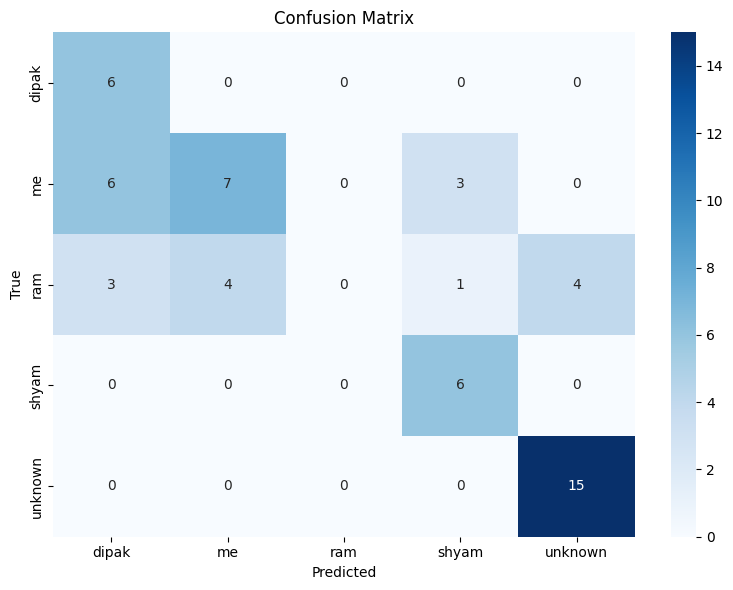

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_x:
    preds = model.predict(images, verbose=0)#predicting each images
    y_true.extend(labels.numpy())#appending the labels/original value
    y_pred.extend(np.argmax(preds, axis=1))#appending the predicted value
#converting to numpy arrary for processing
y_true = np.array(y_true)
y_pred = np.array(y_pred)

#creating a classification_report object
print(classification_report(y_true, y_pred, target_names=class_names))

# creating the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
#saving the model for inference in future
model.save('palm_model.keras')


# plotting the training graphs

ValueError: x and y must have same first dimension, but have shapes (30,) and (25,)

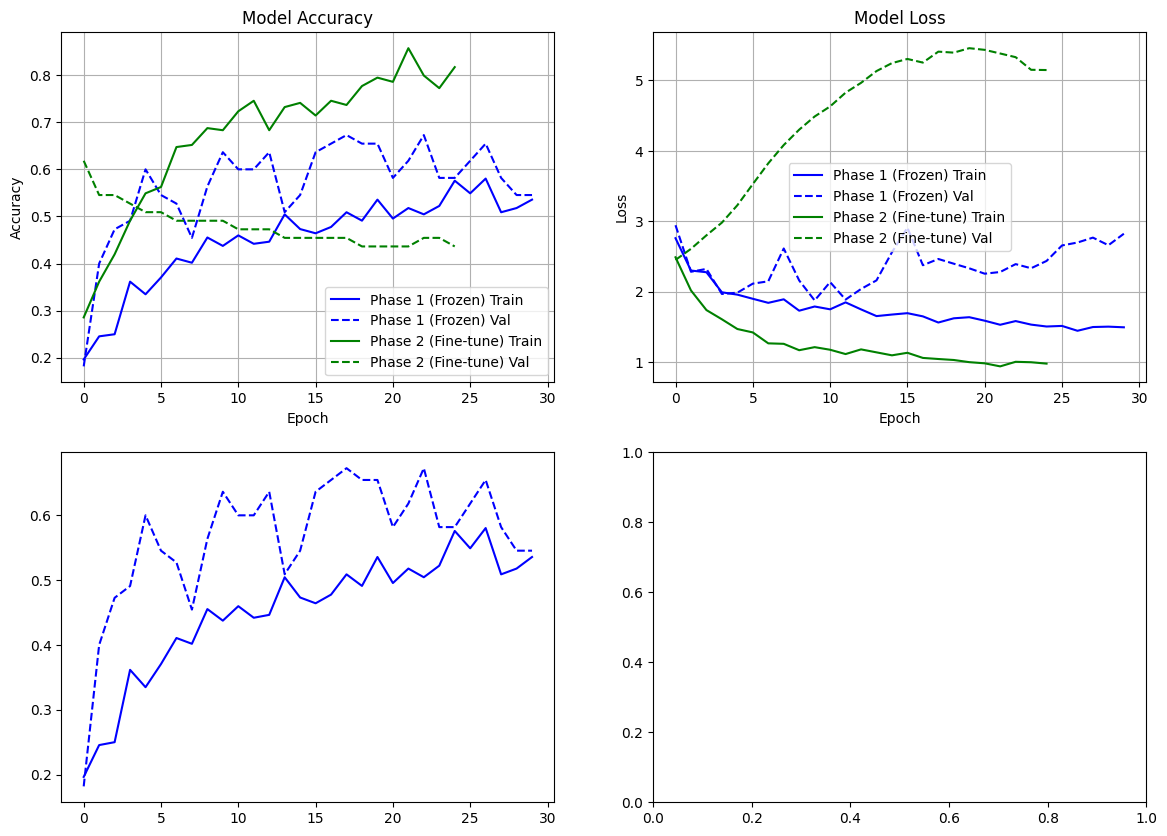

In [ ]:
# This code is generated by AI.
def plot_history(history1, history2):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = ['blue', 'green']
    
    for idx, (history, title) in enumerate(zip([history1, history2], ['Phase 1 (Frozen)', 'Phase 2 (Fine-tune)'])):
        # Accuracy
        axes[0, 0].plot(history.history['accuracy'], 
                        label=f'{title} Train', color=colors[idx], linestyle='-')
        axes[0, 0].plot(history.history['val_accuracy'], 
                        label=f'{title} Val', color=colors[idx], linestyle='--')
        
        # Loss
        axes[0, 1].plot(history.history['loss'], 
                        label=f'{title} Train', color=colors[idx], linestyle='-')
        axes[0, 1].plot(history.history['val_loss'], 
                        label=f'{title} Val', color=colors[idx], linestyle='--')
    
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Combined accuracy
    axes[1, 0].plot(history1.history['accuracy'], 
                    label='Phase 1 Train', color='blue', linestyle='-')
    axes[1, 0].plot(history1.history['val_accuracy'], 
                    label='Phase 1 Val', color='blue', linestyle='--')
    axes[1, 0].plot(range(len(history1.history['accuracy'])), 
                    history2.history['accuracy'], label='Phase 2 Train', color='green', linestyle='-')
    axes[1, 0].plot(range(len(history1.history['accuracy'])), 
                    history2.history['val_accuracy'], label='Phase 2 Val', color='green', linestyle='--')
    axes[1, 0].axvline(x=len(history1.history['accuracy'])-1, 
                       color='red', linestyle=':', label='Phase Transition')
    axes[1, 0].set_title('Combined Accuracy (All Epochs)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_history(train_1, train_2)


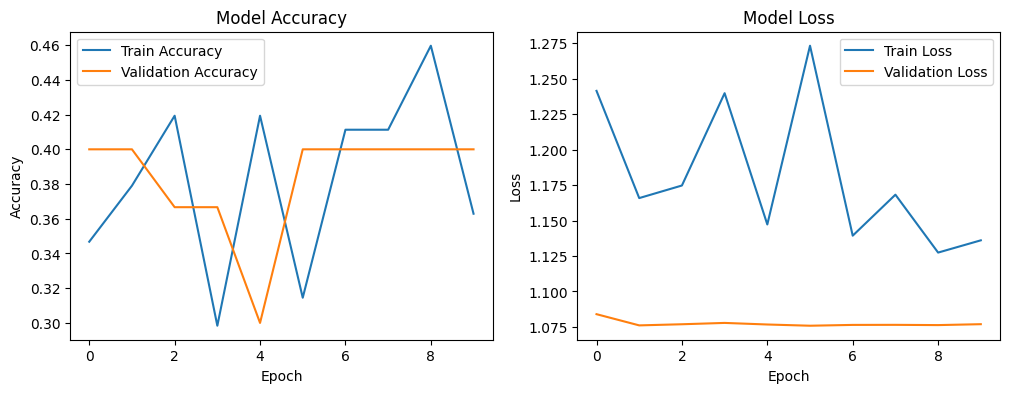

In [40]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()